<h1>Pre-Processing: One Dataframe<h1>

 This notebook is responsible for aggregating the data set into one large dataframe/parquet

In [1]:
from pyspark.sql import SparkSession, functions as F
import findspark
findspark.init()
import pandas as pd
from datetime import *
from pyspark.sql.types import DateType
import seaborn as sns
import matplotlib.pyplot as plt

Read in all the data and group it accordingly

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "8g")
    .config("spark.sql.parquet.enableVectorizedReader", False)
    .getOrCreate()
)

22/08/06 15:38:29 WARN Utils: Your hostname, Sens-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
22/08/06 15:38:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/06 15:38:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<h2>Combination and Feature Selection<h2>

Combining dataframes into single dataframe and performing basic feature selection (removing features that clearly have no causal relationship with demand and driver pay).

In [3]:
sdf_taxi = spark.read.parquet('../data/raw/fhv_taxi_data/*.parquet')
sdf_taxi.count()

377940135

In [4]:
# Ensure only using valid records

sdf_taxi = sdf_taxi.where((F.col('trip_time') > 0)
        & (F.col('driver_pay') > 0)
        & (F.col('base_passenger_fare') > 0)
        & ((F.col('Hvfhs_license_num') == 'HV0002') | (F.col('Hvfhs_license_num') == 'HV0003') | (F.col('Hvfhs_license_num') == 'HV0004')| (F.col('Hvfhs_license_num') == 'HV0005')))
sdf_taxi.count()

# Roughly 34 million invalid records removed

344192887

In [5]:
sdf_taxi = sdf_taxi.select("Pickup_datetime", "DropOff_datetime", "PULocationID", "DOLocationID", "driver_pay", "trip_time")

In [6]:
sdf_weather = spark.read.option("header", True).csv('../data/raw/KNYJACKS2.csv')

Remove weather variables that are strongly correlated because they will be useless when conducting analysis or using in a regression formula

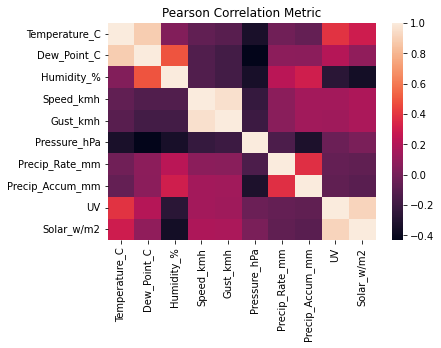

In [7]:
df = pd.read_csv('../data/raw/KNYJACKS2.csv')
sns.heatmap(df.corr())
# wow that's easy...

plt.title('Pearson Correlation Metric')
plt.show()

Remove dew point because dew point is a combination of temperature and humidity (reflected by the large correlation with both). Only need one of gust and speed because they're strongly correlated, chose speed. Precip_rate gives a more accurate description of weather at the time of taxi booking so choose this over precip_accumulation.

In [8]:
sdf_weather = sdf_weather.select("Date","Time","Temperature_C","Humidity_%", "Speed_kmh", "Precip_Rate_mm", "Pressure_hPa")

# Convert to required format for aggregating

sdf_weather = sdf_weather.withColumn(
    'Datetime',
    F.concat_ws(" ", "Date", "Time"))

sdf_weather = sdf_weather.withColumn(
    'Datetime',
    F.to_timestamp("Datetime", "yyyy/MM/dd hh:mm a"))

sdf_weather = sdf_weather.withColumn(
    'Date',
    F.to_date("Date", "yyyy/MM/dd"))

# Only want 1 weather record for each hour, so choose the first record of every hour

#print(sdf_weather.count())

sdf_weather = sdf_weather.where(F.minute("Datetime") <= 4)

#print(sdf_weather.count())

sdf_weather = sdf_weather.withColumn(
    'Hour',
    F.hour("Datetime"))

sdf_weather = sdf_weather.drop("Time", "Datetime")

In [9]:
sdf = sdf_taxi.join(sdf_weather, (F.to_date("Pickup_datetime") == F.col("Date")) & (F.hour("Pickup_datetime") == F.col("Hour")), "inner")

In [10]:
# Add day of week feature because this is likely to be correlated with taxi demand

sdf = sdf.withColumn(
    'Day_of_week',
    F.dayofweek("Date"))

# Remove repeated/no-longer useful columns and rename columns for matching format in column titles

sdf = sdf.drop("Pickup_datetime", "DropOff_datetime").withColumnRenamed('PULocationID', 'PU_Location_ID').withColumnRenamed('DOLocationID', 'DO_Location_ID').withColumnRenamed('driver_pay', 'Driver_pay').withColumnRenamed('trip_time', 'Trip_time')
sdf.show(1, vertical = True)

-RECORD 0--------------------
 PU_Location_ID | 245        
 DO_Location_ID | 251        
 Driver_pay     | 7.48       
 Trip_time      | 579        
 Date           | 2019-02-01 
 Temperature_C  | -8.44      
 Humidity_%     | 36.0       
 Speed_kmh      | 3.54       
 Precip_Rate_mm | 0.0        
 Pressure_hPa   | 1031.49    
 Hour           | 11         
 Day_of_week    | 6          
only showing top 1 row



<h2>Outlier detection<h2>

Invalid taxi journey's have already been removed (negative/zero trip length, negative/zero driver pay, negative/zero passenger fare and journey's with invalid HVFHS liscenses).

In [11]:
sdf.count()

224171189

Remove trips with dates outside of desired range

In [12]:
sdf = sdf.where(F.col("Date") >= '2019-02-01')
sdf = sdf.where(F.col("Date") <= '2020-01-31')
sdf.count()

223436103

Remove overly long trips, > 4 hours

In [13]:
sdf = sdf.where(F.col("Trip_time") < 60*60*4)
sdf.count()

223428464

Trips with pickup or dropoff ID's outside of the desired range 1-263

In [15]:
sdf = sdf.where((F.col("PU_Location_ID") >= 1) & (F.col("PU_Location_ID") <= 263))
sdf = sdf.where((F.col("DO_Location_ID") >= 1) & (F.col("DO_Location_ID") <= 263))
sdf.count()

215685351